In [1]:
import os
import math

import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageDraw

from scorefield.models.ddpm.denoising_diffusion import Unet
from scorefield.models.ddpm.denoising_diffusion_1d import Unet1D, GaussianDiffusion1D, Dataset1D, Trainer1D
from scorefield.models.ddpm.gaussian_diffusion import Diffusion
from scorefield.utils.rl_utils import load_config
from scorefield.utils.utils import gen_goals, prepare_input, get_url_image, overlay_image
from scorefield.utils.diffusion_utils import bilinear_interpolate

import matplotlib.pyplot as plt


/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
overlay_image('map.png', './Untitled_Folder_1/*.png', (0,0))

FileNotFoundError: [Errno 2] No such file or directory: './Untitled_Folder_1/*.png'

In [2]:
# Args
config_dir = "./scorefield/configs/diffusion.yaml"
args = load_config(config_dir)
device = args['device']

model_path = os.path.join(args['log_path'], args['model_path'])

map_img = Image.open("map.png")
bounds = args['bounds']

In [3]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8)
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, x_t, t):
        score_map = super().forward(obs, t)
        score = bilinear_interpolate(score_map, x_t)    # output: (B,2)
        return score

img_size = args['image_size']
noise_steps = args['noise_steps']
train_lr = args['train_lr']
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = Diffusion(
    bounds,
    input_size = (2,), 
    noise_steps= noise_steps,
    device=device,
    beta_start=1e-4,
    beta_end=2e-3,
)

optim = torch.optim.Adam(params=model.parameters(), lr=train_lr)

In [4]:
epochs = args['epochs']
batch_size = args['batch_size']
goal_num = args['goal_num']

goals = gen_goals(bounds, goal_num)

assert batch_size % goal_num == 0, 'batch size has to be divided by the goal number'
n = batch_size // goal_num
expanded_goals = goals.unsqueeze(1).expand(-1, n, -1)

for iters in tqdm(range(goal_num * epochs)):
    optim.zero_grad()
    
    # x0 = (torch.rand(goal_num, 2, device=device, dtype=torch.float32)*2 -1.) * 0.01 + goals
    random_offsets = (torch.rand(*expanded_goals.shape, device=goals.device, dtype=goals.dtype) * 2 - 1.) * 0.01
    x0 = (expanded_goals + random_offsets).view(-1,2)
    obs = prepare_input(map_img, img_size, goal_pos=x0, circle_rad=2)
    t = diffusion.sample_timesteps(batch_size).to(device)
    
    x_noisy, noise = diffusion.forward_diffusion(x0, t)
    noise_pred = model(obs, x_noisy, t)
    loss =  F.l1_loss(noise, noise_pred)
    loss.backward()
    optim.step()
    
    if iters % 500 == 0:
        print(f"iter {iters}: {loss.item()}")


  0%|          | 1/4000 [00:00<59:46,  1.12it/s]

iter 0: 0.7595564126968384


 13%|█▎        | 501/4000 [04:30<31:38,  1.84it/s]

iter 500: 0.4076395630836487


 25%|██▌       | 1001/4000 [09:00<26:39,  1.87it/s]

iter 1000: 0.5393219590187073


 38%|███▊      | 1501/4000 [13:29<22:31,  1.85it/s]

iter 1500: 0.40423884987831116


 50%|█████     | 2001/4000 [18:01<18:38,  1.79it/s]

iter 2000: 0.4633934497833252


 63%|██████▎   | 2501/4000 [22:31<13:31,  1.85it/s]

iter 2500: 0.3079361915588379


 75%|███████▌  | 3001/4000 [27:02<09:12,  1.81it/s]

iter 3000: 0.09636562317609787


 88%|████████▊ | 3501/4000 [31:33<04:29,  1.85it/s]

iter 3500: 0.19867689907550812


100%|██████████| 4000/4000 [36:04<00:00,  1.85it/s]


In [5]:
torch.save(model.state_dict(), "./logs/pretrained/ddpm.pt")
# model.load_state_dict(torch.load('./model.pt'))

In [12]:
x_T = torch.tensor([[-0.5, 0.5]]*10, device=device, dtype=torch.float32)
obs_T = prepare_input(args, map_img, goal_pos=x_T, circle_rad=2)

x = x_T
model.eval()
with torch.no_grad():
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        t = (torch.ones(1) * i).long().to(device)
        predicted_noise = model(obs_T, x, t)
        alpha = diffusion.alpha[t]
        alpha_hat = diffusion.alpha_hat[t]
        beta = diffusion.beta[t]
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                    * predicted_noise) + torch.sqrt(beta) * noise

299it [00:31,  9.41it/s]


299it [00:05, 54.99it/s]


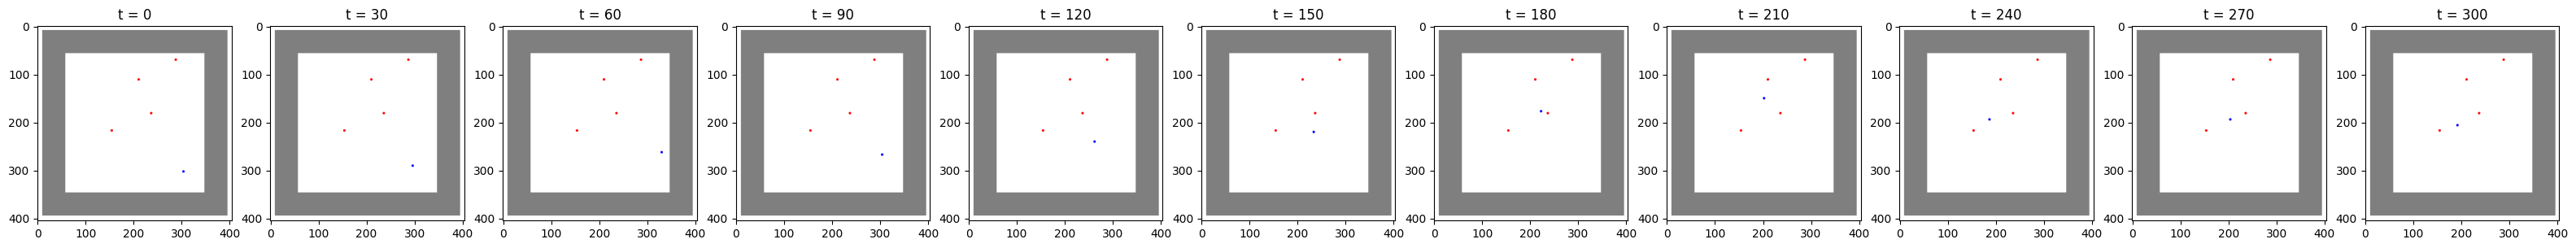

In [11]:
from scorefield.utils.utils import draw_goal_samples

c = 10
fig,axs = plt.subplots(1, c + 1, figsize=(40,40))
axs = axs.flatten()
T = diffusion.noise_steps
step_size = int(T / c)


x_T = torch.tensor([[0.5, 0.5]], device=device, dtype=torch.float32)
obs_T = prepare_input(map_img, img_size, x_T, circle_rad=2)

x = x_T
x_trace = [x]
model.eval()
with torch.no_grad():
    for i in tqdm(reversed(range(1, noise_steps)), position=0):
        if (T-1-i) % step_size == 0:
            k = (T-1-i) // step_size
            img_sample = draw_goal_samples(map_img,goals.cpu(), x.cpu())
            axs[k].imshow(img_sample)
            axs[k].set_title(f't = {T-1-i}')
        
        t = (torch.ones(1) * i).long().to(device)
        predicted_noise = model(obs_T, x, t)
        alpha = diffusion.alpha[t]
        alpha_hat = diffusion.alpha_hat[t]
        beta = diffusion.beta[t]
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) \
                    * predicted_noise) + torch.sqrt(beta) * noise
        x_trace.append(x)
        
    img_sample = draw_goal_samples(map_img, goals.cpu(), x.cpu())
    axs[-1].imshow(img_sample)
    axs[-1].set_title(f't = {T}')